# Часть 1

## Этап 1

In [35]:
import os

import numpy as np
import pandas as pd

import optuna

import seaborn as sns
import matplotlib.pyplot as plt
from sklift.viz import plot_qini_curve, plot_uplift_curve

from scipy import stats
from scipy.stats import pearsonr, spearmanr
from statsmodels.stats.proportion import proportions_ztest

from sklearn.model_selection import train_test_split
from sklift.metrics import uplift_auc_score, qini_auc_score, uplift_at_k

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from causalml.inference.meta import BaseXClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from utils import cramers_v, eta_squared, plot_uplift_results, custom_uplift_by_percentile

In [4]:
df = pd.read_csv("uplift_fp_data.csv")
df.head(5)

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,treatment,target
0,10,1,142.44,1,0,1,0,1,1,0
1,6,2,329.08,1,1,2,1,2,0,0
2,7,1,180.65,0,1,1,1,2,1,0
3,9,4,675.83,1,0,2,1,2,0,0
4,2,0,45.34,1,0,0,0,2,1,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recency          64000 non-null  int64  
 1   history_segment  64000 non-null  int64  
 2   history          64000 non-null  float64
 3   mens             64000 non-null  int64  
 4   womens           64000 non-null  int64  
 5   zip_code         64000 non-null  int64  
 6   newbie           64000 non-null  int64  
 7   channel          64000 non-null  int64  
 8   treatment        64000 non-null  int64  
 9   target           64000 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 4.9 MB


In [6]:
df.describe()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,treatment,target
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,1.481969,242.085656,0.551031,0.549719,0.748469,0.502250,1.319609,0.334172,0.146781
std,3.507592,1.544514,256.158608,0.497393,0.497526,0.697936,0.499999,0.678254,0.471704,0.353890
min,1.000000,0.000000,29.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,64.660000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,6.000000,1.000000,158.110000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
75%,9.000000,2.000000,325.657500,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000
max,12.000000,6.000000,3345.930000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000


В датасете отсутствуют пропуски

## Этап 2

### EDA


#### Распределение целевой переменной между контрольной и тестовой группами

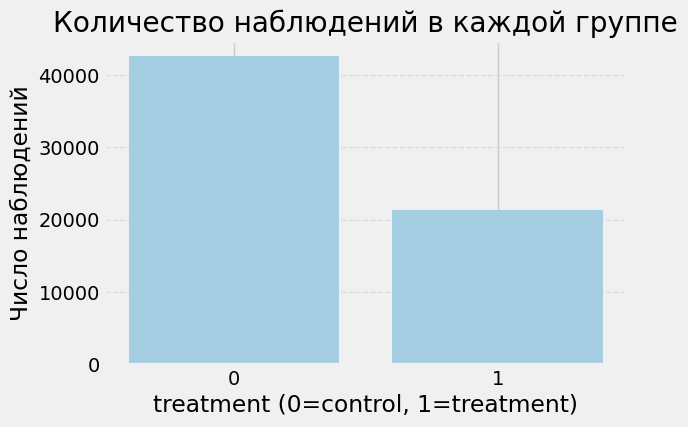

In [5]:
counts = df['treatment'].value_counts().sort_index()
conv_rates = df.groupby('treatment')['target'].mean()

plt.figure(figsize=(6,4))
plt.bar(counts.index.astype(str), counts.values)
plt.title('Количество наблюдений в каждой группе')
plt.xlabel('treatment (0=control, 1=treatment)')
plt.ylabel('Число наблюдений')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

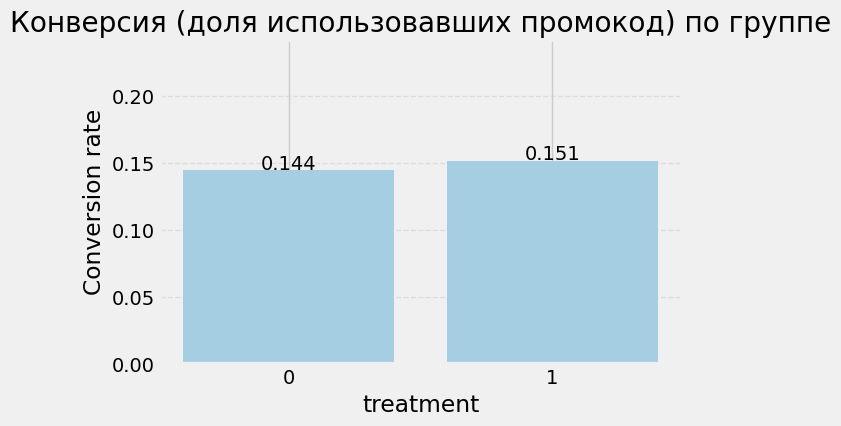

In [6]:
plt.figure(figsize=(6,4))
plt.bar(conv_rates.index.astype(str), conv_rates.values)
plt.title('Конверсия (доля использовавших промокод) по группе')
plt.xlabel('treatment')
plt.ylabel('Conversion rate')
plt.ylim(0, max(conv_rates.values)*1.6)
for i, v in enumerate(conv_rates.values):
    plt.text(i, v+0.001, f"{v:.3f}", ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

Выборки несбалансированны, значит S и T модели нам не подходят. Скорее всего будем использовать X или R <br>
Разница в конверсии менее чем в 1 процент. Пока выглядит сомнительно, необходимо провести проверку на статистическую значимость.

## Этап 2

### Проверка на статистическую значимость

**Обоснование:**
- Целевая переменная бинарная (0/1) — сравниваем пропорции двух независимых выборок.
- Подходящий тест: хи-квадрат. Если выборка маленькая, то Фишер.
- Здесь размер выборки большой (n ~ 64k), поэтому chi2 будет корректен.

In [7]:
ct = pd.crosstab(df['treatment'], df['target'])
print('Контингентная таблица (treatment x target):')
print(ct)

Контингентная таблица (treatment x target):
target         0     1
treatment             
0          36457  6156
1          18149  3238


In [8]:
chi2, chi2_p, _, _ = stats.chi2_contingency(ct)
print(f"Chi2 test: chi2={chi2:.4f}, p-value={chi2_p:.4g}")
if chi2_p < 0.05:
    print("Разница между контрольной и тестовой группами статистически значима.")
else:
    print("Разница между контрольной и тестовой группами не статистически значима.")

Chi2 test: chi2=5.4171, p-value=0.01994
Разница между контрольной и тестовой группами статистически значима.


Тест показал, что между группами есть статистически значимые различия. Ура!

### Построение корреляций

Большинство признаков в датасете не имеют порядковой зависимости<br>
Рассчитывать для них корреляцию, как для числовых фичей - странно. <br>
Переведу их к категориальным фичам и рассчитаю eta^2

In [9]:
corr_df = df.copy()
corr_df['history_segment'] = corr_df['history_segment'].astype('category')
corr_df['mens'] = corr_df['mens'].astype('category')
corr_df['womens'] = corr_df['womens'].astype('category')
corr_df['zip_code'] = corr_df['zip_code'].astype('category')
corr_df['newbie'] = corr_df['newbie'].astype('category')
corr_df['channel'] = corr_df['channel'].astype('category')
corr_df['treatment'] = corr_df['treatment'].astype('category')
corr_df['target'] = corr_df['target'].astype('category')

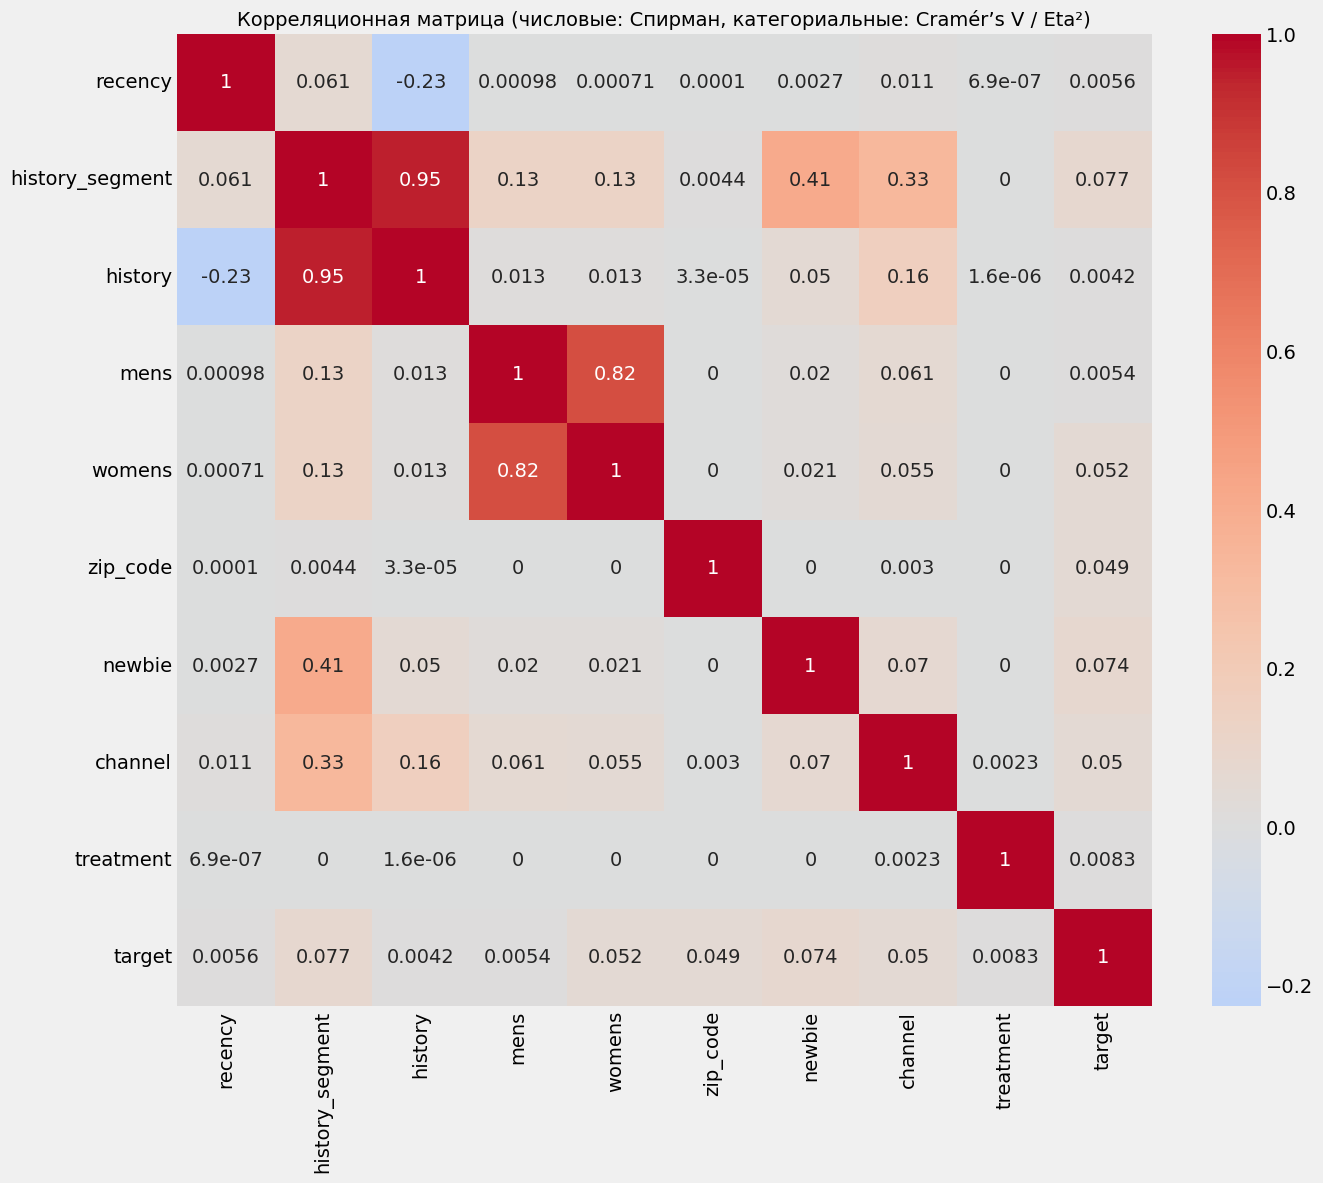

In [10]:
# --- Определяем типы ---
date_cols = corr_df.select_dtypes(include=["datetime", "datetimetz"]).columns.tolist()
num_cols = corr_df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in corr_df.columns if c not in num_cols and c not in date_cols]

# Убираем даты
df_corr = corr_df.drop(columns=date_cols, errors="ignore")
cols = df_corr.columns

# --- Строим корреляционную матрицу ---
corr_matrix = pd.DataFrame(np.zeros((len(cols), len(cols))), index=cols, columns=cols)

for i, col1 in enumerate(cols):
    for j, col2 in enumerate(cols):
        if i > j:
            continue
        if col1 in num_cols and col2 in num_cols:
            corr, _ = stats.spearmanr(df_corr[col1], df_corr[col2], nan_policy='omit')
        elif col1 in cat_cols and col2 in cat_cols:
            corr = cramers_v(df_corr[col1], df_corr[col2])
        elif col1 in num_cols and col2 in cat_cols:
            corr = eta_squared(df_corr[col1], df_corr[col2])
        elif col2 in num_cols and col1 in cat_cols:
            corr = eta_squared(df_corr[col2], df_corr[col1])
        else:
            corr = np.nan
        corr_matrix.loc[col1, col2] = corr
        corr_matrix.loc[col2, col1] = corr

# --- Визуализация ---
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Корреляционная матрица (числовые: Спирман, категориальные: Cramér’s V / Eta²)", fontsize=14)
plt.show()

Не густо. <br>
Наибольшая корреляция с history_segment, newbie, womens, channel и zip_code

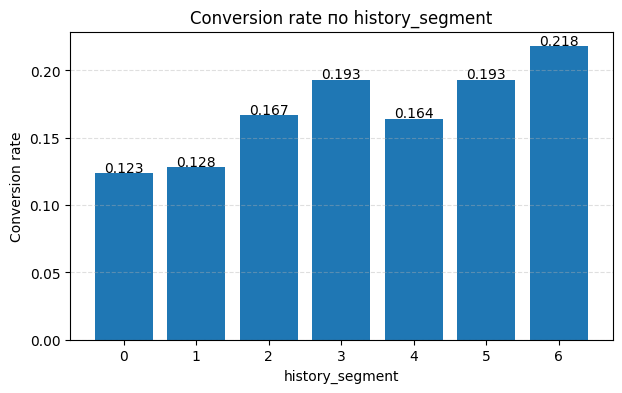

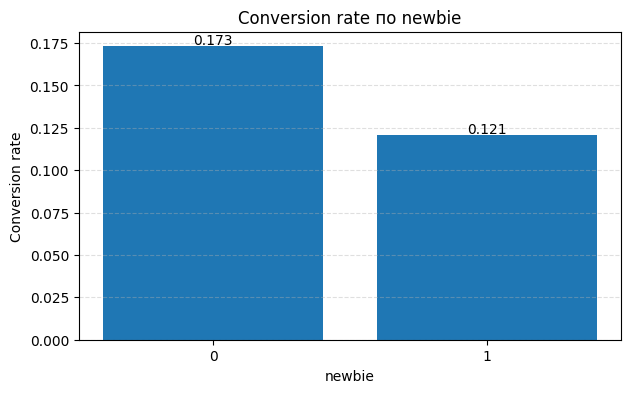

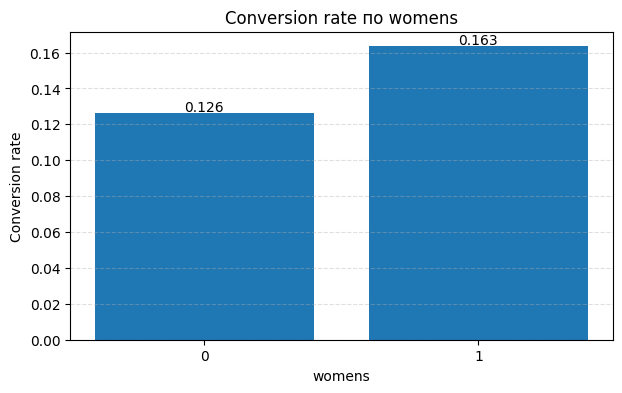

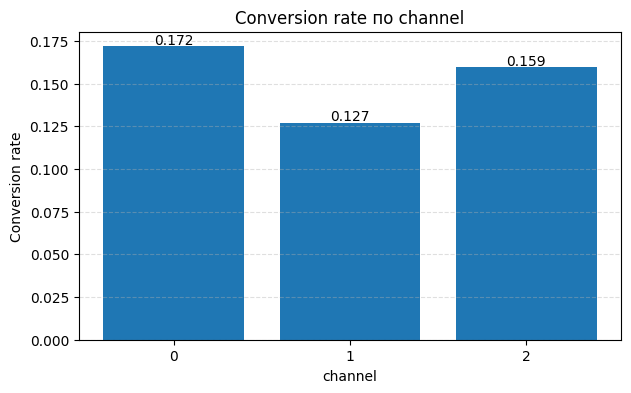

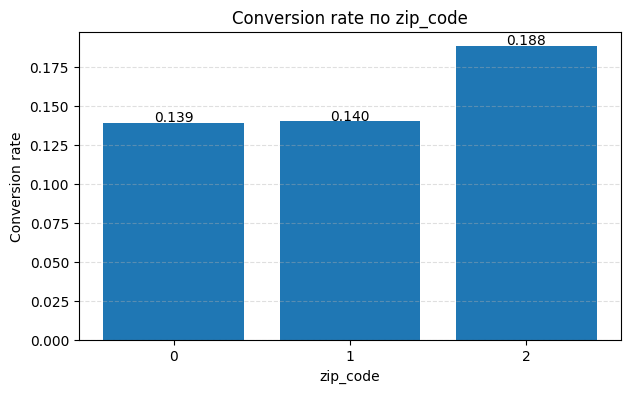

In [ ]:
def plot_conv_hist(features: str):

    conv_df = df.groupby(features)['target'].mean()
    plt.figure(figsize=(7,4))
    plt.bar(conv_df.index.astype(str), conv_df.values)
    plt.title(f'Conversion rate по {features}')
    plt.xlabel(features)
    plt.ylabel('Conversion rate')
    for i,v in enumerate(conv_df.values):
        plt.text(i, v+0.001, f"{v:.3f}", ha='center')
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.show()


main_features = ["history_segment", "newbie", "womens", "channel", "zip_code"]

for features in main_features:
    plot_conv_hist(features)

## Этап 3

В качестве бейзлайна я возьму обычные uplift-деревья. <br>
После я буду обучать X-learner и R-learner т.к. присутствует дисбаланс классов, а эти модели хорошо справляются с этой проблемой

### Разбиение выборки на тренировочную и тестовую

При работе с бейзлайном и двумя следующими моделями, я не буду приводить признаки к категориальным фичам, а вот при улучшении модели - уже попробую этот подход

In [7]:
# разделим данные на признаки и целевую переменную
X = df.drop(['target'], axis=1)  # все столбцы, кроме целевой переменной
y = df['target']  # целевая переменная (например, количество поездок)

# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                    stratify=df[['target', 'treatment']],
                                    random_state=42)

# 1. Разделяем обучающую выборку на treatment=1 и treatment=0
X_treat = X_train[X_train['treatment'] == 1].drop('treatment', axis=1)
y_treat = y_train[X_train['treatment'] == 1]

X_control = X_train[X_train['treatment'] == 0].drop('treatment', axis=1)
y_control = y_train[X_train['treatment'] == 0]

### Обучение выбранного бейзлайна

In [8]:
# обучим модель RandomForestClassifier
model = RandomForestClassifier(
    n_estimators=100,  
    max_depth=6,       
    random_state=42,  
    # verbose=1         
)

model.fit(X_train, y_train)

# чтобы оценить uplift-эффекта для каждого пользователя:
# 1. Создаём копию тестовых данных
X_test_treated = X_test.copy()
X_test_control = X_test.copy()

# 2. Устанавливаем значение признака treatment
X_test_treated['treatment'] = 1  # С воздействием
X_test_control['treatment'] = 0  # Без воздействия

# 3. Предсказываем результаты для обоих случаев
y_pred_treated = model.predict_proba(X_test_treated)[:,1]
y_pred_control = model.predict_proba(X_test_control)[:,1]

# 4. Вычисляем uplift как разницу между предсказаниями
uplift = y_pred_treated - y_pred_control

# Добавляем предсказанный uplift к тестовым данным для анализа
X_test['predicted_uplift'] = uplift

### Расчет метрик для выбранного бейзлайна на тестовой выборке

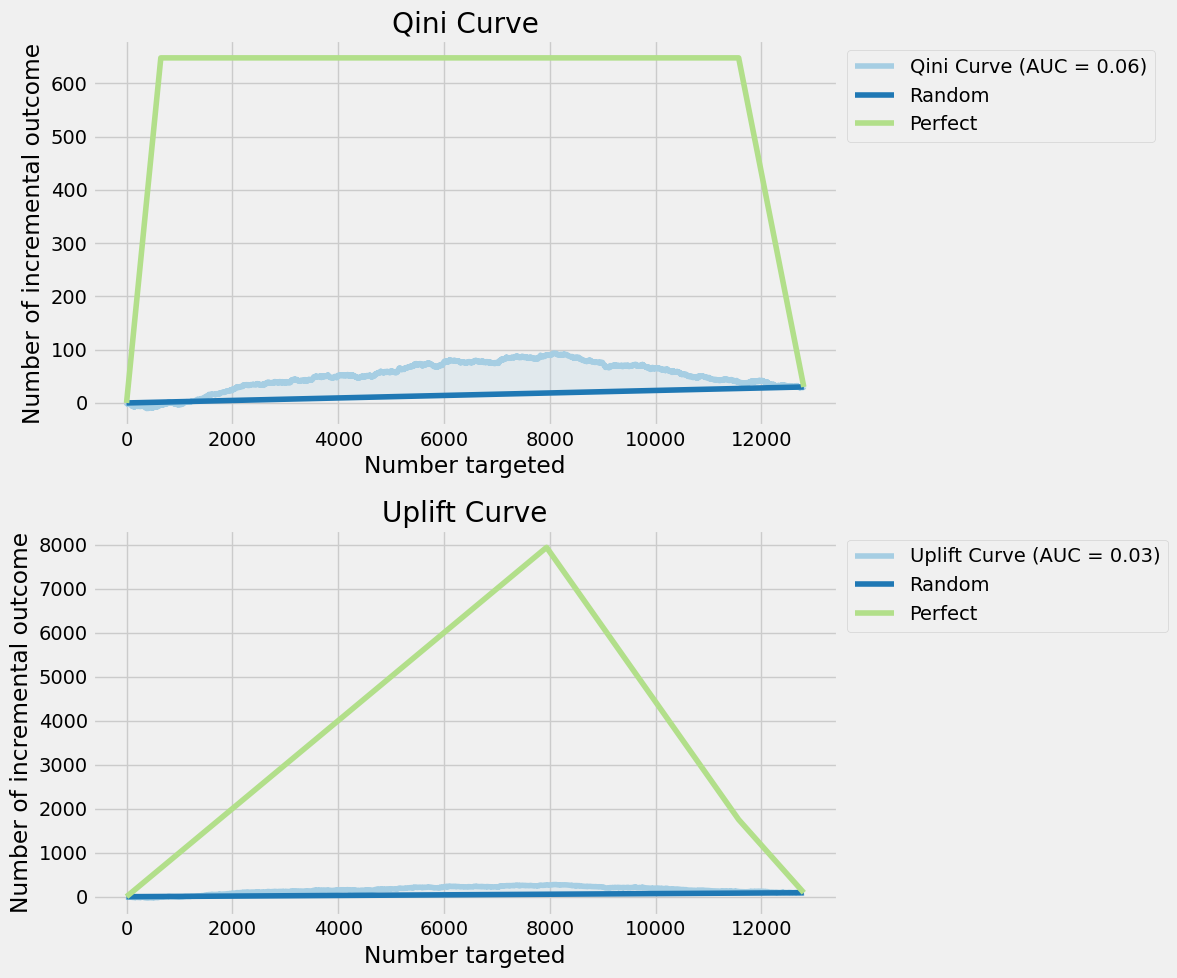

📊 Метрики модели:
Qini AUC:    0.0605
Uplift AUC:  0.0272
Uplift@30%:  0.0373
{'qini_auc': 0.060462019000512776, 'uplift_auc': 0.027228460168374588, 'uplift@30%': np.float64(0.037324797490232806)}


In [9]:
metrics_baseline = plot_uplift_results(
    y_true=y_test,
    uplift_pred=X_test["predicted_uplift"],
    treatment=X_test["treatment"],
    k=0.3
)

print(metrics_baseline)


# Обучение 2 моделей 

### Обучение модели 1

Попрбую обучить R-learn

In [10]:
# разделим данные на признаки и целевую переменную
X = df.drop(['target'], axis=1)  # все столбцы, кроме целевой переменной
y = df['target']  # целевая переменная (например, количество поездок)

# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                    stratify=df[['target', 'treatment']],
                                    random_state=42)

# 1. Разделяем обучающую выборку на treatment=1 и treatment=0
X_treat = X_train[X_train['treatment'] == 1].drop('treatment', axis=1)
y_treat = y_train[X_train['treatment'] == 1]

X_control = X_train[X_train['treatment'] == 0].drop('treatment', axis=1)
y_control = y_train[X_train['treatment'] == 0]

In [11]:
from causalml.inference.meta import BaseRClassifier
from xgboost import XGBClassifier, XGBRegressor

X = df.drop(['target'], axis=1)  
y = df['target']  

# разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                    stratify=df[['target', 'treatment']],
                                    random_state=42)

features = df.drop(columns=['target','treatment']).columns
T = X_train.treatment.values  # 1 - treatment, 0 - control
X_train = X_train[features]
y_train = y_train.values  # целевая переменная
T_test = X_test.treatment.values


# инициализируем R-learner с моделями XGBoost
# outcome_learner — модель для предсказания исхода без учёта воздействия
# effect_learner — модель для оценки эффекта воздействия
# propensity_learner — модель для оценки вероятности получения воздействия
r_learner = BaseRClassifier(
    outcome_learner=XGBClassifier(
        n_estimators=200,
        learning_rate=0.02,
        max_depth=6,
        random_state=42,
        verbosity=0
    ),
    effect_learner=XGBRegressor(
        n_estimators=200,
        learning_rate=0.01,
        max_depth=6,
        random_state=42,
        verbosity=0
    ),
    propensity_learner=XGBClassifier(
        n_estimators=200,
        learning_rate=0.02,
        max_depth=6,
        random_state=42,
        verbosity=0
    )
)

# инициализируем массив для propensity score
e_x = np.zeros(len(X_train))
T_test = X_test.treatment.values

# обучаем модель для оценки propensity score
model_e = XGBClassifier(n_estimators=100, 
                        learning_rate=0.02, 
                        max_depth=3, 
                        random_state=42, 
                        verbosity=0)
model_e.fit(X_train, T)
e_x = model_e.predict_proba(X_train)[:, 1]

# обучаем модель R-learner
r_learner.fit(
    X=X_train,
    treatment=T,
    y=y_train,
    p=e_x,
    verbose=True
)


### Получение метрик по модели 1

In [12]:
# получаем оценки uplift-эффекта для тестовой выборки
uplift_scores = r_learner.predict(X_test.drop(columns=['treatment']).values)

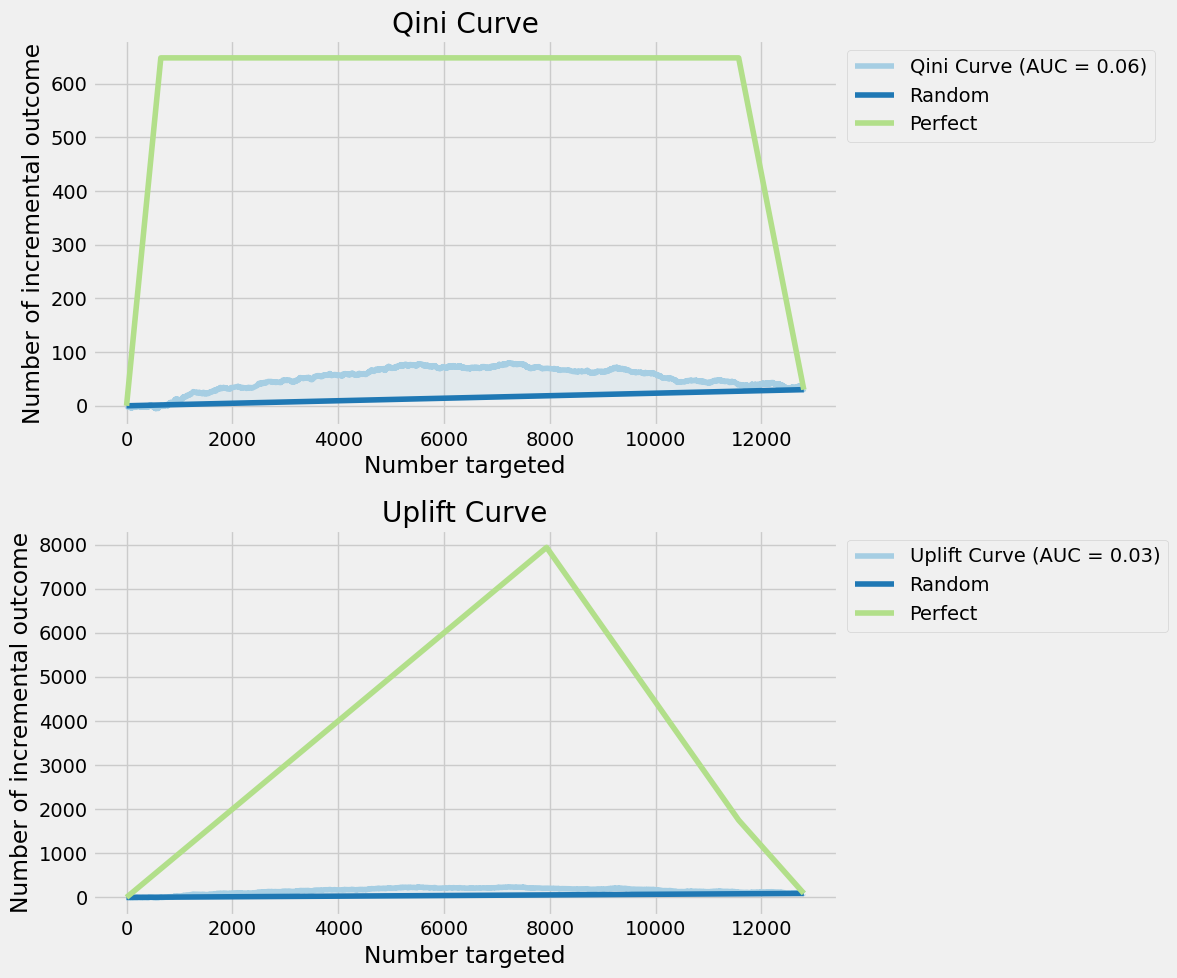

📊 Метрики модели:
Qini AUC:    0.0610
Uplift AUC:  0.0274
Uplift@30%:  0.0463
{'qini_auc': 0.06095714475060682, 'uplift_auc': 0.027391917384123884, 'uplift@30%': np.float64(0.04625919542543214)}


In [13]:
metrics_baseline = plot_uplift_results(
    y_true=y_test,
    uplift_pred=uplift_scores.squeeze(),
    treatment=X_test["treatment"],
    k=0.3
)

print(metrics_baseline)


### Обучение модели 2

Обучаю X-модель

In [14]:
# разделим данные на признаки и целевую переменную
X = df.drop(['target'], axis=1)  # все столбцы, кроме целевой переменной
y = df['target']  # целевая переменная (например, количество поездок)

# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                    stratify=df[['target', 'treatment']],
                                    random_state=42)

# 1. Разделяем обучающую выборку на treatment=1 и treatment=0
X_treat = X_train[X_train['treatment'] == 1].drop('treatment', axis=1)
y_treat = y_train[X_train['treatment'] == 1]

X_control = X_train[X_train['treatment'] == 0].drop('treatment', axis=1)
y_control = y_train[X_train['treatment'] == 0]

In [15]:
# используем Random Forest для outcome- и effect-моделей
rf_clf = RandomForestClassifier(
    random_state=42,
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=5,
    n_jobs=-1,
    verbose=0
)
rf_reg = RandomForestRegressor(
    random_state=42,
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=5,
    n_jobs=-1,
    verbose=0
)

# для propensity score используем XGBoost
propensity_model = XGBClassifier(
    random_state=42,
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1,
    verbosity=0
)
propensity_model.fit(X_train.drop('treatment', axis=1).values, X_train['treatment'].values)
# получаем propensity score для train и test
p_train = propensity_model.predict_proba(X_train.drop('treatment', axis=1).values)[:, 1]
p_test = propensity_model.predict_proba(X_test.drop('treatment', axis=1).values)[:, 1]

x_learner = BaseXClassifier(
    outcome_learner=rf_clf,
    control_name=0,
    effect_learner=rf_reg,
)

# обучаем X-learner с передачей propensity score
x_learner.fit(
    X=X_train.drop('treatment', axis=1).values,
    treatment=X_train['treatment'].values,
    y=y_train.values,
    p=p_train
)

In [16]:
uplift_pred = x_learner.predict(
    X_test.drop('treatment', axis=1).values,
    p=p_test
)

### Получение метрик по модели 2

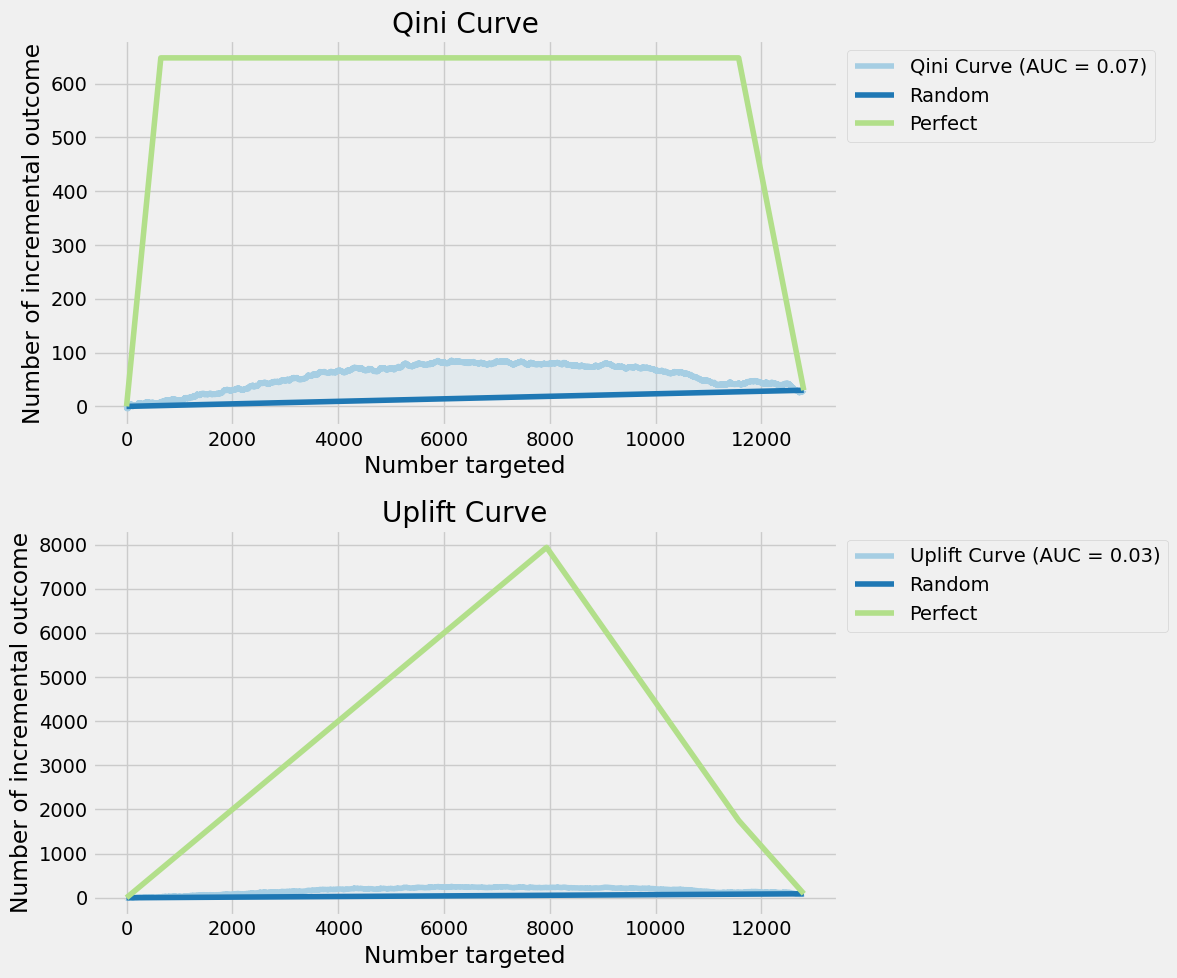

📊 Метрики модели:
Qini AUC:    0.0697
Uplift AUC:  0.0310
Uplift@30%:  0.0490
{'qini_auc': 0.06968720259336501, 'uplift_auc': 0.031001259051023862, 'uplift@30%': np.float64(0.048994800185890613)}


In [ ]:
metrics_baseline = plot_uplift_results(
    y_true=y_test,
    uplift_pred=uplift_pred.squeeze(),
    treatment=X_test["treatment"],
    k=0.3
)

print(metrics_baseline)


X-learner показал лучшие результаты по трём метрикам <br>
X-learner и R-learner показывают результаты лучше, чем решающие деревья, т.к. они заточены под работу с несбалансированными выборками

# Часть 2

## Этап 1
Улучшите бейзлайн выбранной модели

Для начала, я приведу признаки к категориальным переменным

In [20]:
df_with_cat = df.copy()
df_with_cat['history_segment'] = df_with_cat['history_segment'].astype('category')
df_with_cat['mens'] = df_with_cat['mens'].astype('boolean')
df_with_cat['womens'] = df_with_cat['womens'].astype('boolean')
df_with_cat['zip_code'] = df_with_cat['zip_code'].astype('category')
df_with_cat['newbie'] = df_with_cat['newbie'].astype('boolean')
df_with_cat['channel'] = df_with_cat['channel'].astype('category')


In [26]:
from sklearn.compose import ColumnTransformer

# разделим данные на признаки и целевую переменную
X = df_with_cat.drop(['target'], axis=1)  # все столбцы, кроме целевой переменной
y = df_with_cat['target']  # целевая переменная (например, количество поездок)

# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                    stratify=df_with_cat[['target', 'treatment']],
                                    random_state=42)

# 1. Разделяем обучающую выборку на treatment=1 и treatment=0
X_treat = X_train[X_train['treatment'] == 1]
y_treat = y_train[X_train['treatment'] == 1]

X_control = X_train[X_train['treatment'] == 0]
y_control = y_train[X_train['treatment'] == 0]


# Категориальные и числовые признаки
categorical_cols = ['history_segment', 'zip_code', 'channel']
boolean_cols = ['mens', 'womens', 'newbie']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols + boolean_cols]

# Создаем трансформер
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
        ('bool', 'passthrough', boolean_cols),
        ('num', 'passthrough', numeric_cols),
    ])

X_train = preprocessor.fit_transform(X_train)
X_control = preprocessor.transform(X_control)
X_treat = preprocessor.transform(X_treat)
X_test = preprocessor.transform(X_test)


# Получим имена новых колонок (если нужно)
ohe_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_features = list(ohe_features) + boolean_cols + numeric_cols
X_control = pd.DataFrame(X_control, columns=all_features).drop('treatment', axis=1)
X_treat = pd.DataFrame(X_treat, columns=all_features).drop('treatment', axis=1)
X_test = pd.DataFrame(X_test, columns=all_features)
X_train = pd.DataFrame(X_train, columns=all_features)

Смотрю как улучшилась модель

In [31]:
# используем Random Forest для outcome- и effect-моделей
rf_clf = RandomForestClassifier(
    random_state=42,
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=5,
    n_jobs=-1,
    verbose=0
)
rf_reg = RandomForestRegressor(
    random_state=42,
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=5,
    n_jobs=-1,
    verbose=0
)

# для propensity score используем XGBoost
propensity_model = XGBClassifier(
    random_state=42,
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1,
    verbosity=0
)
propensity_model.fit(X_train.drop('treatment', axis=1).values, X_train['treatment'].values)
# получаем propensity score для train и test
p_train = propensity_model.predict_proba(X_train.drop('treatment', axis=1).values)[:, 1]
p_test = propensity_model.predict_proba(X_test.drop('treatment', axis=1).values)[:, 1]

x_learner = BaseXClassifier(
    outcome_learner=rf_clf,
    control_name=0,
    effect_learner=rf_reg,
)

# обучаем X-learner с передачей propensity score
x_learner.fit(
    X=X_train.drop('treatment', axis=1).values,
    treatment=X_train['treatment'].values,
    y=y_train.values,
    p=p_train
)

In [33]:
uplift_pred = x_learner.predict(
    X_test.drop('treatment', axis=1).values,
    p=p_test
)

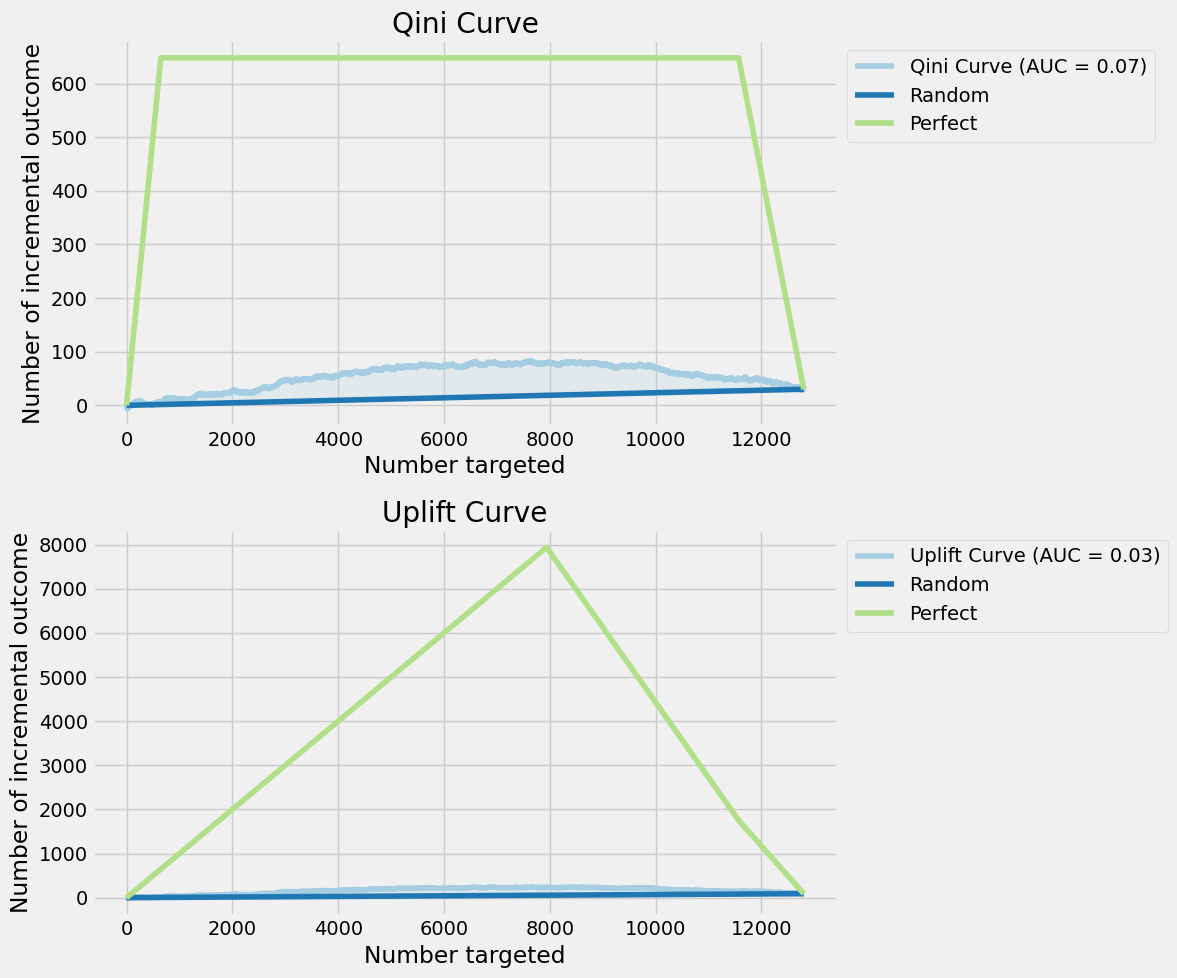

📊 Метрики модели:
Qini AUC:    0.0660
Uplift AUC:  0.0293
Uplift@30%:  0.0412
{'qini_auc': 0.06602048997520059, 'uplift_auc': 0.029318244981792033, 'uplift@30%': np.float64(0.04118532098453717)}


In [34]:
metrics_baseline = plot_uplift_results(
    y_true=y_test,
    uplift_pred=uplift_pred.squeeze(),
    treatment=X_test["treatment"],
    k=0.3
)

print(metrics_baseline)


Метрики снизились, поэтому продолжу работать с числовыми фичами

### Подбор гиперпараметров

In [23]:
# разделим данные на признаки и целевую переменную
X = df.drop(['target'], axis=1)  # все столбцы, кроме целевой переменной
y = df['target']  # целевая переменная (например, количество поездок)

# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                    stratify=df[['target', 'treatment']],
                                    random_state=42)

# 1. Разделяем обучающую выборку на treatment=1 и treatment=0
X_treat = X_train[X_train['treatment'] == 1]
y_treat = y_train[X_train['treatment'] == 1]

X_control = X_train[X_train['treatment'] == 0]
y_control = y_train[X_train['treatment'] == 0]

In [31]:
def objective(trial):
    # Ускоренные гиперпараметры для пробного запуска
    n_estimators_clf = trial.suggest_int('n_estimators_clf', 140, 400, step=20)
    max_depth_clf = trial.suggest_int('max_depth_clf', 5, 20)
    min_samples_leaf_clf = trial.suggest_int('min_samples_leaf_clf', 2, 20)

    n_estimators_reg = trial.suggest_int('n_estimators_reg', 140, 400, step=20)
    max_depth_reg = trial.suggest_int('max_depth_reg', 5, 20)
    min_samples_leaf_reg = trial.suggest_int('min_samples_leaf_reg', 2, 20)

    learning_rate = trial.suggest_float('learning_rate', 0.005, 0.3)

    # Создаем модели
    rf_clf = RandomForestClassifier(
        n_estimators=n_estimators_clf,
        max_depth=max_depth_clf,
        min_samples_leaf=min_samples_leaf_clf,
        n_jobs=-1,
        random_state=42
    )

    rf_reg = RandomForestRegressor(
        n_estimators=n_estimators_reg,
        max_depth=max_depth_reg,
        min_samples_leaf=min_samples_leaf_reg,
        n_jobs=-1,
        random_state=42
    )

    xgb_prop = XGBClassifier(
        n_estimators=50,  # ускоряем обучение
        max_depth=3,
        learning_rate=learning_rate,
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=-1,
        verbosity=0,
        random_state=42
    )

    # Обучаем propensity model
    xgb_prop.fit(X_train.drop('treatment', axis=1).values, X_train['treatment'].values)
    p_train = xgb_prop.predict_proba(X_train.drop('treatment', axis=1).values)[:, 1]
    p_test = xgb_prop.predict_proba(X_test.drop('treatment', axis=1).values)[:, 1]

    # Обучаем X-learner
    x_learner = BaseXClassifier(
        outcome_learner=rf_clf,
        effect_learner=rf_reg,
        control_name=0
    )
    x_learner.fit(
        X=X_train.drop('treatment', axis=1).values,
        treatment=X_train['treatment'].values,
        y=y_train.values,
        p=p_train
    )

    # Предсказания uplift
    uplift_pred = x_learner.predict(X_test.drop('treatment', axis=1).values, p=p_test)
    treatment_test = X_test['treatment'].values

    uplift_topk = uplift_at_k(y_true=y_test, uplift=uplift_pred.squeeze(), treatment=X_test["treatment"], strategy='by_group', k=0.3)

    return uplift_topk

# Создаем и запускаем исследование
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)

# Выводим лучшие гиперпараметры
print("Best hyperparameters: ", study.best_params)
print("Best score: ", study.best_value)


[I 2025-11-04 17:31:32,308] A new study created in memory with name: no-name-05c23f56-f67b-41ec-9d92-eae1e8fa19f1
[I 2025-11-04 17:31:45,070] Trial 0 finished with value: 0.0532679056934488 and parameters: {'n_estimators_clf': 300, 'max_depth_clf': 11, 'min_samples_leaf_clf': 8, 'n_estimators_reg': 180, 'max_depth_reg': 15, 'min_samples_leaf_reg': 9, 'learning_rate': 0.19495112221513644}. Best is trial 0 with value: 0.0532679056934488.
[I 2025-11-04 17:31:58,385] Trial 1 finished with value: 0.03842532113090774 and parameters: {'n_estimators_clf': 140, 'max_depth_clf': 14, 'min_samples_leaf_clf': 2, 'n_estimators_reg': 240, 'max_depth_reg': 17, 'min_samples_leaf_reg': 13, 'learning_rate': 0.0946989451315347}. Best is trial 0 with value: 0.0532679056934488.
[I 2025-11-04 17:32:12,498] Trial 2 finished with value: 0.048190981865907506 and parameters: {'n_estimators_clf': 180, 'max_depth_clf': 14, 'min_samples_leaf_clf': 18, 'n_estimators_reg': 280, 'max_depth_reg': 15, 'min_samples_leaf_

Best hyperparameters:  {'n_estimators_clf': 280, 'max_depth_clf': 7, 'min_samples_leaf_clf': 14, 'n_estimators_reg': 360, 'max_depth_reg': 13, 'min_samples_leaf_reg': 2, 'learning_rate': 0.06330003933723012}
Best score:  0.05795664260090727


``` python
Best hyperparameters:  {
    'n_estimators_clf': 280, 
    'max_depth_clf': 7, 
    'min_samples_leaf_clf': 14, 
    'n_estimators_reg': 360, 
    'max_depth_reg': 13, 
    'min_samples_leaf_reg': 2, 
    'learning_rate': 0.06330003933723012
    }
```
Best score:  0.05795664260090727

## Этап 2

### Визуализация результатов

In [ ]:
from utils import custom_uplift_by_percentile

In [41]:
# Финальная модель:

# используем Random Forest для outcome- и effect-моделей
rf_clf = RandomForestClassifier(
    random_state=42,
    n_estimators=280,
    max_depth=7,
    min_samples_leaf=14,
    n_jobs=-1,
    verbose=0
)
rf_reg = RandomForestRegressor(
    random_state=42,
    n_estimators=360,
    max_depth=13,
    min_samples_leaf=2,
    n_jobs=-1,
    verbose=0
)

# для propensity score используем XGBoost
propensity_model = XGBClassifier(
    random_state=42,
    n_estimators=200,
    max_depth=10,
    learning_rate=0.06330003933723012,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1,
    verbosity=0
)
propensity_model.fit(X_train.drop('treatment', axis=1).values, X_train['treatment'].values)
# получаем propensity score для train и test
p_train = propensity_model.predict_proba(X_train.drop('treatment', axis=1).values)[:, 1]
p_test = propensity_model.predict_proba(X_test.drop('treatment', axis=1).values)[:, 1]

x_learner = BaseXClassifier(
    outcome_learner=rf_clf,
    control_name=0,
    effect_learner=rf_reg,
)

# обучаем X-learner с передачей propensity score
x_learner.fit(
    X=X_train.drop('treatment', axis=1).values,
    treatment=X_train['treatment'].values,
    y=y_train.values,
    p=p_train
)

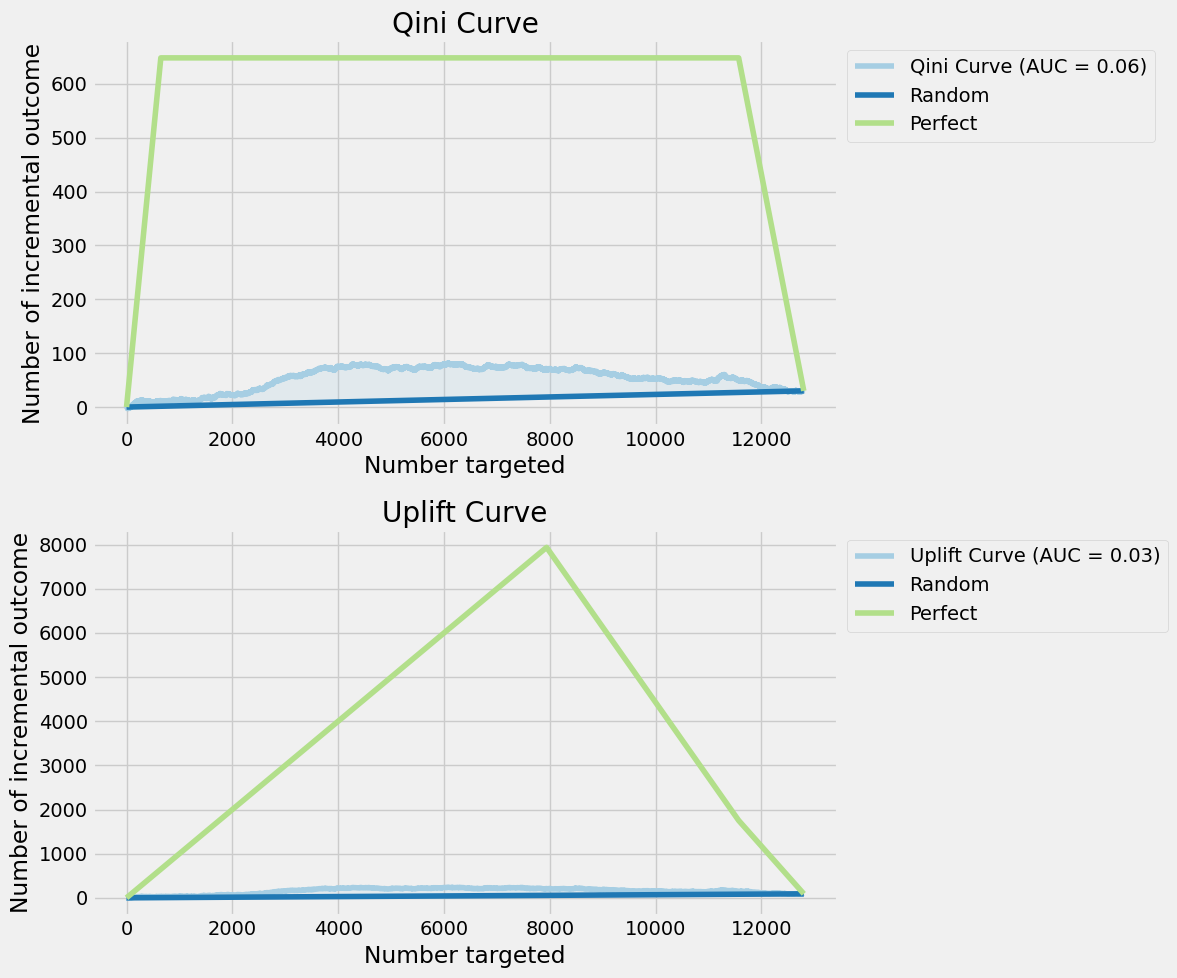

📊 Метрики модели:
Qini AUC:    0.0642
Uplift AUC:  0.0284
Uplift@30%:  0.0541
{'qini_auc': 0.0642228502159971, 'uplift_auc': 0.02843148626991485, 'uplift@30%': np.float64(0.05405037830690734)}


In [42]:
uplift_pred = x_learner.predict(
    X_test.drop('treatment', axis=1).values,
    p=p_test
)

metrics_baseline = plot_uplift_results(
    y_true=y_test,
    uplift_pred=uplift_pred.squeeze(),
    treatment=X_test["treatment"],
    k=0.3
)

print(metrics_baseline)

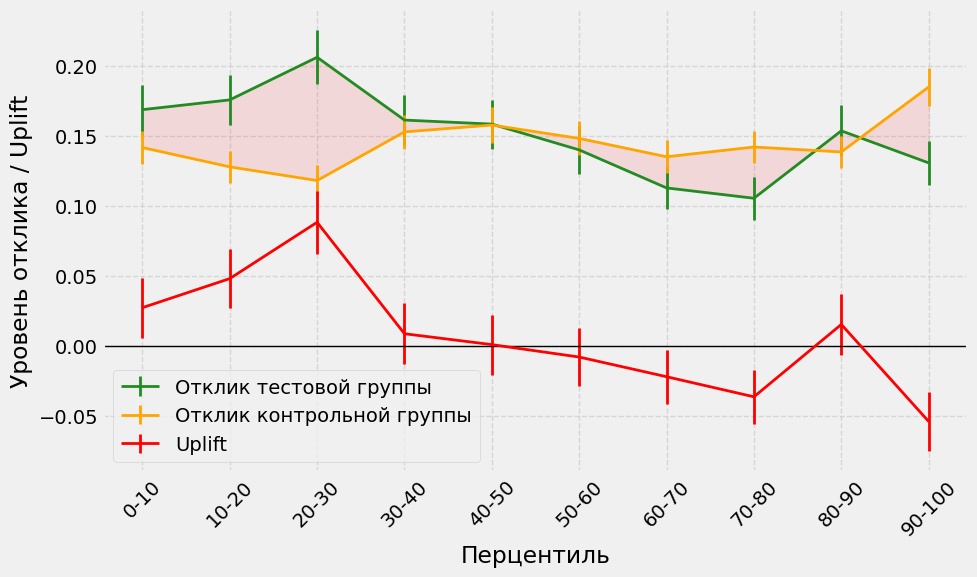

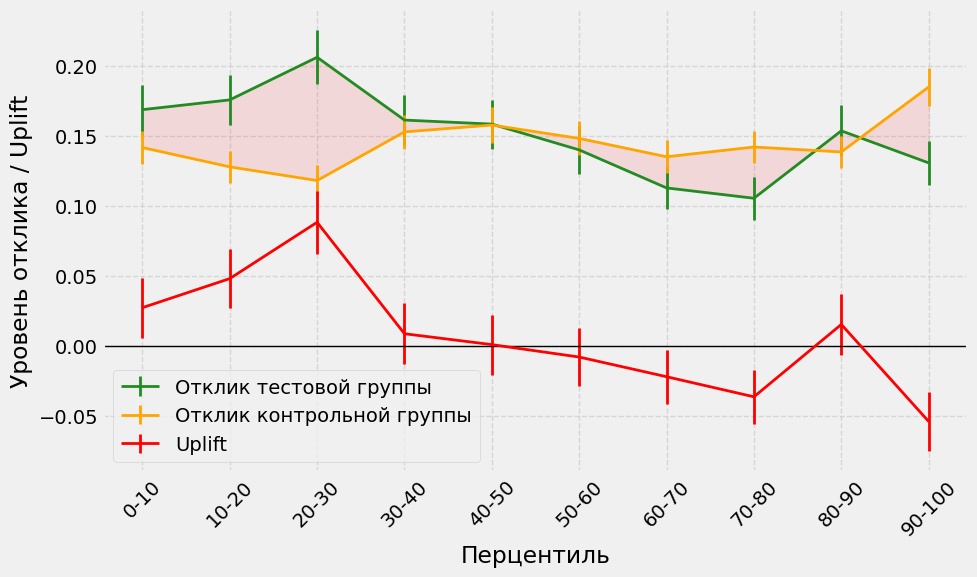

In [43]:
custom_uplift_by_percentile(
    y_true=y_test,
    uplift=uplift_pred.squeeze(),
    treatment=X_test["treatment"],
    kind='line', bins=10, string_percentiles=True, 
    figsize=(10, 6), title=None
)

Удалось добиться метрики по ТОП 30% uplift > 0.05. Это отличный результат <br>
На графике перцентилей видно, долю клиентов, совершивших целевое действие в обеих группах, если брать определённый Top-k по uplift. Посчитан uplift для разных перцентилей и видно, что наиболее значительные различия получаются при ТОП-30 не удивительно, ведь мы и оптимизировали именно эту метрику.

# Этап 3

In [44]:
class UpliftModelInference:
    """
    Класс для инференса uplift модели.
    """

    def __init__(self, model, propensity_model, feature_names, logger=None):
        """
        Инициализация класса.
        
        Аргументы:
            model: обученный X-Learner (BaseXClassifier)
            propensity_model: обученная модель для propensity score (например, XGBClassifier)
            feature_names: список признаков для предсказания 
            logger: объект для логирования (по умолчанию None)
        """
        self.model = model
        self.propensity_model = propensity_model
        self.feature_names = feature_names
        self.logger = logger

        if self.logger:
            self.logger.info("UpliftModelInference инициализирован")

    def _transform_data(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Преобразование данных для модели (если нужно).
        """
        if self.logger:
            self.logger.debug("Преобразование входных данных размерности %s", X.shape)

        # Модель использует "сырые" фичи без перекодировки

        return X[self.feature_names]

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        """
        Получение предсказаний uplift.
        """

        if X.empty:
            if self.logger:
                self.logger.error("Предоставлен пустой датафрейм")
            return np.array([])

        if X.isnull().any().any():
            if self.logger:
                self.logger.warning("Входные данные содержат пропущенные значения. "
                                    "Они будут заменены медианой.")
            X = X.fillna(X.median(numeric_only=True)).fillna(X.mode().iloc[0])

        # Проверяем наличие всех необходимых признаков
        missing_features = set(self.feature_names) - set(X.columns)
        if missing_features:
            msg = f"Отсутствуют признаки: {missing_features}"
            if self.logger:
                self.logger.error(msg)
            raise ValueError(msg)

        # Преобразуем данные
        X_prepared = self._transform_data(X)

        # Вычисляем propensity scores
        try:
            p = self.propensity_model.predict_proba(X_prepared.values)[:, 1]
        except Exception as e:
            if self.logger:
                self.logger.error(f"Ошибка при вычислении propensity score: {e}")
            raise e

        # Предсказание uplift через X-Learner
        if self.logger:
            self.logger.debug("Выполняем предсказания uplift")

        try:
            uplift_pred = self.model.predict(X_prepared.values, p=p)
        except Exception as e:
            if self.logger:
                self.logger.error(f"Ошибка при предсказании uplift: {e}")
            raise e

        if self.logger:
            self.logger.info("Предсказания успешно завершены")

        return uplift_pred.squeeze()


In [51]:
feature_names = ['recency', 'history_segment', 'history', 'mens', 'womens', 'zip_code', 'newbie', 'channel']

# Инициализация inference-класса
model = UpliftModelInference(
    model=x_learner,
    propensity_model=propensity_model,
    feature_names=feature_names
)

In [52]:
# Пример инференса
uplift_pred_prod = model.predict(X_test.drop(columns=['treatment']))
print("Пример предсказаний uplift:\n", uplift_pred_prod[:10])

Пример предсказаний uplift:
 [-0.0415518  -0.04316706  0.01807558 -0.03792031  0.04454697  0.05272217
 -0.01499488  0.0215956   0.0154089  -0.01750072]


In [53]:
test_data = pd.DataFrame({
            'recency': [1, 2, 3],
            'history_segment': [1, 2, 3], 
            'history': [100, 200, 300],
            'mens': [1, 0, 1],
            'womens': [0, 1, 0],
            'zip_code': [1, 0, 1],
            'newbie': [0, 1, 0],
            'channel': [1, 2, 0]
        })

In [54]:
# проверка работы класса
model.predict(test_data)

array([-0.04081178, -0.00403777, -0.01422821])